<a href="https://colab.research.google.com/github/oscarld-dl/ML-Workshop/blob/main/Predictive_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

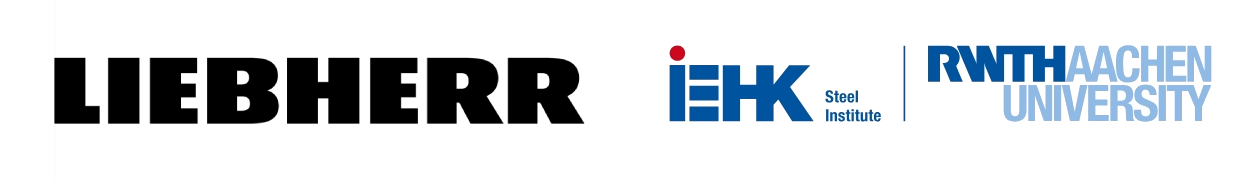

In [ ]:
from IPython.display import Image, display
display(Image("head.jpg"))

# SciML Workshop

RWTH Aachen University, 07.10.2025




***************************************************************************************************************************
**The goal of this workshop is to understand how we have developed the descriptive and predictive analyses using ML/DL tools.**
***************************************************************************************************************************

**Tasks for the Predictive Analysis:**
-------------

1. Understanding **K-Fold Cross-Validation**.
2. Using **scikit.learn** to evaluate different **linear regression models**.
3. Upgrading to **stacked regression models** to improve accuracy.
4. Using the best performing model to **generate the outputs of new synthetic inputs** (after data augmentation)

**Import basic libraries again:**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Import specific libraries:**

[Visit scikit-learn webpage HERE for more information](https://scikit-learn.org/stable/)

In [ ]:
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, Lars, LassoLars, LassoLarsIC, BayesianRidge, MultiTaskLasso, MultiTaskLassoCV, HuberRegressor, ElasticNet, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

**Understanding the Cross-Validation:**

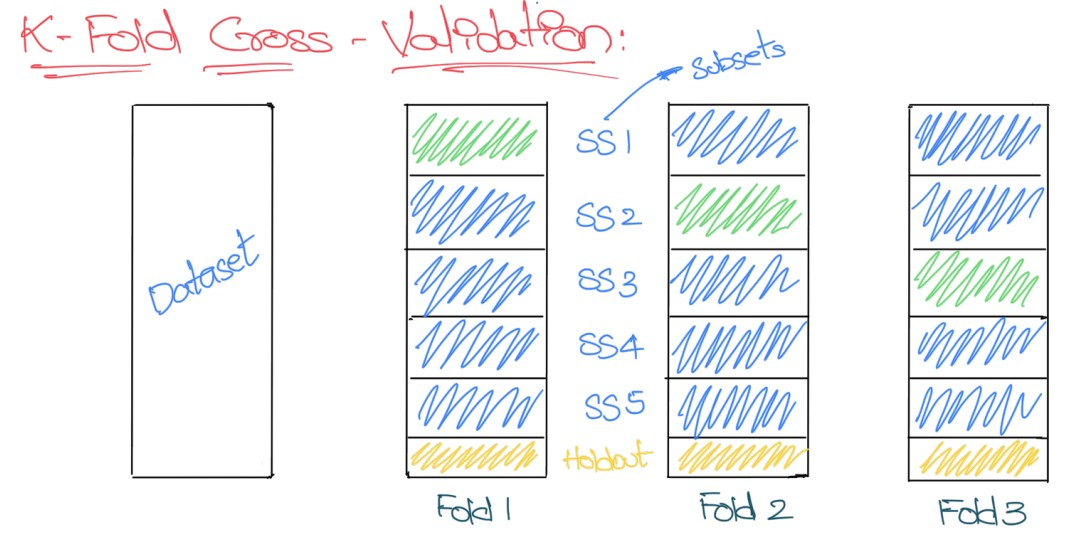

In [ ]:
from IPython.display import Image, display
display(Image("cv.jpg"))

1. Dataset is split into K subsets.
2. The algorithm is then iterated K (fold) times and in each fold different subsets are used as a validation set (green ones)
3. This help us to determine the model's sensitivity to new and unseen data.
4. Finally a holdout/test set is used to evaluate the model.

**Let's gather different models from the library**

1. Why normalization.
2. Why splitting the data.

**Hands-on**

1. Add GB model for Hannes file. Take just the most important ones but GB at the beginning. Then, compare.
2. Try different K folders to see how it takes more computational time to solve. Also to check how accuracy changes.

In [46]:
# Load the Excel file again
df_experimental = pd.read_excel("/content/master.xlsx", sheet_name="experimental")

# Input and output split
X = df_experimental.iloc[:89, 1:12]
# In order to check wheter we have selected the appropiate columns, just:
print(X)
Y = df_experimental.iloc[:89, 12:]

# Normalize inputs and outputs
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

X_train_full, X_holdout, Y_train_full, Y_holdout = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=42, shuffle=True)

# Define models to test
base_models = {
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor(),
    "SVR (RBF Kernel)": SVR(kernel='rbf')
}


results_per_model = {}

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)  # Reduce repeats for speed if needed

# This is telling scikit-learn: split the data into 5 equal parts (aka 5 folds). Then train on 4 folds and validate on 1. Repeat this 5
# times, each time with a different random fold split. The random_state is just for reproducibility each time I run the code.

for name, model in base_models.items():
    print(f"Evaluating {name}...")
    multi_model = MultiOutputRegressor(model)
    r2_scores = []

    for train_idx, test_idx in rkf.split(X_train_full):
        X_train, X_val = X_train_full[train_idx], X_train_full[test_idx]
        Y_train, Y_val = Y_train_full[train_idx], Y_train_full[test_idx]

        multi_model.fit(X_train, Y_train)
        Y_pred = multi_model.predict(X_val)

        fold_r2 = r2_score(Y_val, Y_pred, multioutput='raw_values')  # List of R² for each output
        r2_scores.append(fold_r2)

    # Average R² per output
    r2_scores = np.array(r2_scores)
    avg_r2_per_output = np.mean(r2_scores, axis=0)
    results_per_model[name] = avg_r2_per_output

results_df = pd.DataFrame(results_per_model, index=Y.columns).T
results_df["Average R² Score"] = results_df.mean(axis=1)
#Sort
results_df.sort_values(by="Average R² Score", ascending=False, inplace=True)

# Save
results_df.to_csv("/content/models_performance_CV.csv", index=True)
print("Cross-validation results:")
print(results_df)

# Now we focus on the best performing model and test it using the holdout set from the first split
best_model_name = results_df.index[0]
print(f"Training {best_model_name} on full training set and evaluating on holdout...")

final_model = MultiOutputRegressor(base_models[best_model_name])
final_model.fit(X_train_full, Y_train_full)
Y_pred_holdout = final_model.predict(X_holdout)

holdout_r2 = r2_score(Y_holdout, Y_pred_holdout, multioutput='raw_values')
print(f"Holdout R² per output: {holdout_r2}")
print(f"Average Holdout R²: {np.mean(holdout_r2):.3f}")

         C  $H_{T1}$  $H_{T2}$   P       d  $\alpha$  Pearlite  $Cryo_{T}$  \
0   0.0014       920       830   4  0.0335      0.90      0.10        -125   
1   0.0014       940       810   4  0.0935      0.50      0.50         -75   
2   0.0014       920       790   4  0.0335      0.75      0.25        -125   
3   0.0020       880       830   4  0.0935      0.50      0.50        -125   
4   0.0014       900       830   2  0.0335      0.90      0.10        -100   
..     ...       ...       ...  ..     ...       ...       ...         ...   
82  0.0014       880       850   4  0.0935      0.75      0.25        -125   
83  0.0014       880       810  10  0.0935      0.50      0.50        -100   
84  0.0014       920       790   2  0.0935      0.50      0.50        -100   
85  0.0020       880       810  10  0.0635      0.50      0.50        -100   
86  0.0017       940       830   4  0.0935      0.90      0.10        -125   

    $Cryo_{t}$  $Temper_{T}$  $Temper_{t}$  
0         3600    

**Data Augmentation**

**Import necessary libraries:**

In [ ]:
import random

In [ ]:
#10000 synthetic input generation

# Define synthetic value ranges for each parameter
synthetic_values = {
    "C": [0.0014, 0.0015, 0.0016, 0.0017, 0.0018, 0.0019, 0.0020],
    "$H_{T1}$": [880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940],
    "$H_{T2}$": [790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850],
    "P": [2, 2.5, 3, 3.5, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10],
    "d": [0.0335, 0.04, 0.0435, 0.05, 0.0535, 0.06, 0.0635, 0.07, 0.0735, 0.08, 0.0835, 0.09, 0.0935],
    "$\\alpha$": [0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90],
    "Pearlite": [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50],
    "$Cryo_{T}$": [-75, -80, -85, -90, -95, -100, -105, -110, -115, -120, -125],
    "$Cryo_{t}$": [2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4250, 4500, 4800],
    "$Temper_{T}$": [150, 160, 175, 200, 210, 225, 230, 240, 245, 250],
    "$Temper_{t}$": [3600, 3800, 4200, 4500, 4800, 5400, 6000, 6300, 6600, 6900, 7200]
}

# Generate random combinations
random_combinations = []
while len(random_combinations) < 10000:  # Keep generating until we have 10000 valid combinations
    combination = {param: random.choice(values) for param, values in synthetic_values.items()}

    if combination["$\\alpha$"] + combination["Pearlite"] == 1:
        random_combinations.append(combination)

# Create DataFrame
synthetic_df = pd.DataFrame(random_combinations)

# Save to excel file or csv using .to_excel:
output_file=r'/content/Synthetic_inputs.csv'
synthetic_df.to_csv(output_file, index=False)

**GB model as the output generator for synthetic input data.**

1. Explain here the other way to split the data using **train_test_split**
2. Explain for what I am using the **original data** (training the model) and for what and how I am using the **new synthetic data**.

In [53]:
# Loading synthetic data for the 10000 predicted outputs
df_synthetic_10000=pd.read_csv(r'/content/Synthetic_inputs.csv').iloc[:10002, :11]
X_synth_10000 = df_synthetic_10000.copy()
X_synth_10000_scaled=scaler_X.transform(X_synth_10000)

ensemble_preds_10000_synthetic=[]
train_r2_scores=[]
test_r2_scores=[]

for i in range(42, 56):
    base_gb = GradientBoostingRegressor(random_state=i)
    gb = MultiOutputRegressor(base_gb)
    gb.fit(X_train, Y_train)

    preds_10000_synthetic=gb.predict(X_synth_10000_scaled)
    ensemble_preds_10000_synthetic.append(preds_10000_synthetic)

# Calculate mean (14 models, one for each random state=i) predictions for synthethic.
ensemble_preds_10000_synthetic=np.stack(ensemble_preds_10000_synthetic)
Y_10000_synth_mean=np.mean(ensemble_preds_10000_synthetic, axis=0)
Y_10000_synth_physical = scaler_Y.inverse_transform(Y_10000_synth_mean)


# Convertir a DataFrame
output_columns = df_experimental.columns[12:]

Y_10000_df=pd.DataFrame(Y_10000_synth_physical, columns=output_columns)
synthetic_10000_full_df=pd.concat([X_synth_10000.reset_index(drop=True), Y_10000_df], axis=1)

synthetic_10000_full_df.to_csv(r'/content/Synthetic_outputs.csv', index=False)

print("Saved successfully!")

Saved successfully!
